In [ ]:
from packages import *
import tensorflow as tf
from datetime import datetime, timedelta
import time
import pandas as pd
import tensorflow.keras.backend as K
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import *
from sklearn.metrics import classification_report, precision_recall_fscore_support, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.utils import shuffle
%load_ext autoreload
%autoreload 2

# Model
We will be building our models in this notebook.

Some configuration required for tensorflow.

In [ ]:
tf.config.gpu.set_per_process_memory_growth(True)
tf.config.gpu.set_per_process_memory_fraction(.3)
tf.keras.backend.set_image_data_format('channels_last')

## Dataset

In [ ]:
glove_dim = 50
max_length = 300
chunk_count = 100
random_seed = np.random.randint(0, 1000000000)
print('using random_seed: {}'.format(random_seed))
splits = ['train', 'val', 'test'] #60:20:20

In [ ]:
tf_text_filenames = [os.path.join(DATASET_DIR, 'preprocessed', 'tfrecord', 'xext',  #xext temporarily
                                  'review-text-{:02d}.tf'.format(i)) for i in range(chunk_count)]
tf_ix_filenames = [os.path.join(DATASET_DIR, 'preprocessed', 'tfrecord', 'ix', 
                                  'review-ix-{:02d}.tf'.format(i)) for i in range(chunk_count)]
all_stars = (load_data({'review': ['stars']})['review']['stars'] - 1).astype(np.int32)# this is so that stars are 0-indexed
N = {}
stars_chunked = all_stars.reshape((chunk_count, 6685900//chunk_count))

class_weights = compute_class_weight('balanced', [0, 1, 2, 3, 4], all_stars)
class_weights = {'five': class_weights, 'ternary': np.array([class_weights[0], class_weights[1:4].sum() , class_weights[4]])}

tf_text, tf_ix, stars= {}, {}, {}

tf_text['train'], tf_text_filenames_val_test, tf_ix['train'], tf_ix_filenames_val_test, stars['train'], stars_val_test \
= train_test_split(tf_text_filenames, tf_ix_filenames, stars_chunked, random_state=random_seed, test_size = .4)

tf_text['val'], tf_text['test'], tf_ix['val'], tf_ix['test'], stars['val'], stars['test'] \
= train_test_split(tf_text_filenames_val_test, tf_ix_filenames_val_test, stars_val_test, random_state=random_seed, test_size = .5)

for split in splits:
    stars[split] = stars[split].reshape(np.product(stars[split].shape))
    N[split] = len(stars[split])

print('({}:{}:{})'.format(len(tf_text['train']), len(tf_text['val']), len(tf_text['test'])))

glove_lookup = load_pickle(os.path.join(GLOVE_DIR, 'glove-{}D-byte-float32.pkl'.format(glove_dim)))
keys_to_ix = load_pickle(os.path.join(GLOVE_DIR, 'glove-byte-keys_to_ix.pkl'))
ix_to_key = {value: key for key, value in keys_to_ix.items()}

unk_vector = np.mean(np.array(list(glove_lookup.values())), axis=0)
null_vector = np.zeros(glove_dim)
glove_lookup[UNK_KEY.encode('ascii')] = unk_vector #if using byte glove dict
glove_lookup[NULL_KEY.encode('ascii')] = null_vector

oops = 0
glove_lookup_array = []
for i in range(len(ix_to_key)):
    if ix_to_key[i] not in glove_lookup:
        oops+=1
    glove_lookup_array.append(glove_lookup.get(ix_to_key[i], null_vector))
glove_lookup_array = np.array(glove_lookup_array, dtype=np.float32)
print('oops {} times.'.format(oops))

@tf.function
def get_review_length(review):
    return tf.cast(tf.reduce_sum(tf.cast(tf.not_equal(review, 0), tf.int8)), tf.int32)

@tf.function
def _parse_function(proto, to_ix):
    # define your tfrecord again. Remember that you saved your image as a string.
    keys_to_features = {'review': tf.io.FixedLenFeature([300,], tf.int64) if to_ix else tf.io.FixedLenFeature([300,], tf.string),}
    
    # Load one example
    parsed_features = tf.io.parse_single_example(proto, keys_to_features)
    
    return parsed_features 

embedding = tf.constant(glove_lookup_array)
@tf.function
def embed(tensor):
    return tf.gather(embedding, tensor)

@tf.function
def add_channel(tensor):
    return tf.expand_dims(tensor, -1)

# 11 GB in memory
# X = []
# x = tf.data.TFRecordDataset(tf_text['train'])
# for y in x :
#     X.append(y)

def make_dataset(batch_size, to_embed=True, to_ix=True, to_str=False, channelize=True, to_ternary_task=False, features= {}): 
    '''
    Note: once created dataset remains the same from iteration to iteration. 
    In Keras.fit, once given steps_per_epoch the data for epochs are not the same.
    Validation data is the same.
    If cell is rerun, then the same order of data will be fed.
    '''
    if to_ternary_task:
        star_mapping = tf.constant([0, 1, 1, 1, 2], dtype=tf.int32)
    def _prepare_star(star):
        if to_ternary_task: return {'stars': tf.gather(star_mapping, star)}
        return {'stars': star}
    def _parse_transform(x):
        parsed = _parse_function(x, to_ix or to_embed)['review']
        out = {key: f(x) for key, f in features.items()}
        if to_ix:
            out['review-ix'] = tf.cast(parsed, tf.int32)
        if to_embed:
            if channelize:
                out['review-embed'] = add_channel(embed(parsed))
            else:
                out['review-embed'] = embed(parsed)
        if to_str:
            pass  
        return out   
    
    shuffle_buffer_size = batch_size * 100
    prefetch_buffer_size = 4
    if to_embed or to_ix: 
        files = tf_ix
    else:
        files = tf_text
    dataset = {}
    num_batches = {}
    for split in splits:
        dataset[split] = tf.data.TFRecordDataset(files[split])
        stars_dataset = tf.data.Dataset.from_tensor_slices(stars[split])
        dataset[split] = tf.data.Dataset.zip((dataset[split], stars_dataset))
        dataset[split] = dataset[split].shuffle(shuffle_buffer_size)
        dataset[split] = dataset[split].repeat()
        dataset[split] = dataset[split].map(lambda x, y: (_parse_transform(x), _prepare_star(y)), num_parallel_calls=12)
        dataset[split] = dataset[split].batch(batch_size)
        dataset[split] = dataset[split].prefetch(prefetch_buffer_size)
        num_batches[split] = N[split] // batch_size
    print('num_batches: {}, batch_size: {}, shuffle_buffer_size: {}, prefetch_buffer_size: {}'.format(num_batches, batch_size, 
                                                                                 shuffle_buffer_size, prefetch_buffer_size))
    return dataset, num_batches

In [ ]:
# %%time
# for i, (x, y) in enumerate(dataset['train']):
#     if i == 500:
#         break
# for i, (x, y) in enumerate(dataset['train']):
#     if i == 500:
#         break
# # Wall time: 30.1 --> 14.2 --> 4.3 s wow (64 batchsize, glovedim = 300)

In [ ]:
# for x_init, y_init in dataset['train']:break

# Models

### BabyBlueberry
Convolutional Model with GLoVe embeddings.

In [ ]:
@rename('all_acc')
def all_class_accuracy(y_true, y_pred):
    return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred) 

def one_class_recall(label):
    @rename('{}_recalll'.format(label))
    def single_class_recall(y_true, y_pred): # (64, 1), (64, 5) should return (64,)
        truth = K.flatten(K.cast(y_true, 'int32'))
        preds = K.cast(K.argmax(y_pred, axis=-1), 'int32')
        recall_mask = K.cast(K.equal(truth, label), 'int32')        
        recall = K.cast(K.equal(preds, truth), 'int32') * recall_mask
        recall = K.cast(K.sum(recall) / K.maximum(K.sum(recall_mask), 1), 'float32')
        return  K.ones(batch_size, dtype='float32') * recall
    return single_class_recall

def one_class_precision(label):
    @rename('{}_precision'.format(label))
    def single_class_precision(y_true, y_pred): # (64, 1), (64, 5) should return (64,)
        truth = K.flatten(K.cast(y_true, 'int32'))
        preds = K.cast(K.argmax(y_pred, axis=-1), 'int32')
        precision_mask = K.cast(K.equal(preds, label), 'int32')          
        precision = K.cast(K.equal(preds, truth), 'int32') * precision_mask
        precision = K.cast(K.sum(precision) / K.maximum(K.sum(precision_mask), 1), 'float32')
        return  K.ones(batch_size, dtype='float32') * precision
    return single_class_precision

In [ ]:
star_metrics = [all_class_accuracy]
star_metrics += [one_class_recall(i) for i in range(5)] + [one_class_precision(i) for i in range(5)]

In [ ]:
def get_kernel_spec(filters, height, width):
    return {'filters':filters, 'height': height, 'width': width}

In [ ]:
class BabyBerry:
    
    def build(dropout_rate, out_units):
        ix_input = Input(shape= (max_length,), name='review-ix')
        glove_input = Input(shape=(max_length, glove_dim), name='review-embed')
        
        
        embedding = Embedding(input_dim=len(glove_lookup_array), output_dim=glove_dim, 
                              input_length=max_length, name='trained_embed')(ix_input)
                        
        average_embedding = Average(name='average_embed')([embedding, glove_input])
        
        x = LSTM(units=500, go_backwards=True, name='lstm')(average_embedding)
        x = Dropout(rate=dropout_rate, name='dropout_1')(x)
        x = Dense(100, activation='relu', name='dense_1')(x)
        out = Dense(out_units, activation='softmax', name='stars')(x)
        
        return tf.keras.models.Model(inputs={'review-embed':glove_input, 'review-ix': ix_input}, 
                                     outputs={'stars': out}, name='BabyBerry')
        
    @tf.function
    def loss_fn(truth, logits):
        loss = tf.keras.losses.sparse_categorical_crossentropy(truth, logits)
        return loss

In [11]:
batch_size = 128
dataset, num_batches = make_dataset(batch_size=batch_size, to_embed=True, to_ix=True, channelize=False, to_ternary_task=False)

num_batches: {'train': 31340, 'val': 10446, 'test': 10446}, batch_size: 128, shuffle_buffer_size: 12800, prefetch_buffer_size: 4


In [12]:
baby = BabyBerry.build(dropout_rate=.1, out_units=5)
adam = tf.keras.optimizers.Adam()
baby.compile(optimizer=adam, metrics={'stars': star_metrics} ,loss={'stars': BabyBerry.loss_fn})

W0608 12:11:37.456258 140342624913216 tf_logging.py:161] <tensorflow.python.keras.layers.recurrent.UnifiedLSTM object at 0x7fa3d00ddf60>: Note that this layer is not optimized for performance. Please use tf.keras.layers.CuDNNLSTM for better performance on GPU.


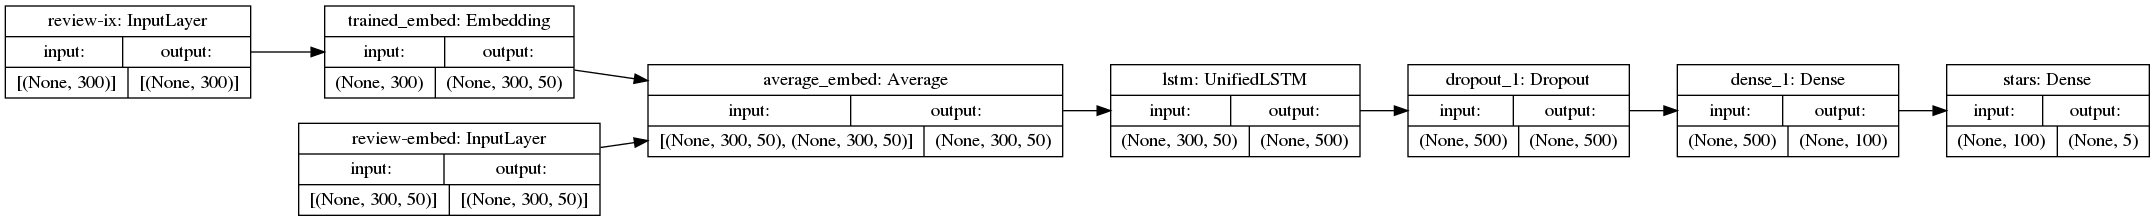

In [13]:
plot_model(baby, show_shapes=True, rankdir='LR', to_file='images/lstm_baby_berry_model.png')

In [14]:
log_dir = os.path.join(SRC_DIR, 'logs', '{}-LSTM-BabyBerry'.format(datetime.fromtimestamp(time.time()).strftime('%d-%m_%H-%M-%S')))
tb = tf.keras.callbacks.TensorBoard(log_dir=log_dir, write_graph=False, update_freq='batch')

In [ ]:
_=baby.fit(dataset['train'], steps_per_epoch=300, epochs=100, 
                             validation_data= dataset['val'], validation_steps=20,
                             callbacks=[tb], class_weight=class_weights['five'], verbose=1)

Epoch 1/100
300/300 [==============================] - 63s 210ms/step - loss: 1.3225 - all_acc: 0.4605 - 0_recalll: 0.3871 - 1_recalll: 0.0108 - 2_recalll: 0.0367 - 3_recalll: 0.1129 - 4_recalll: 0.8744 - 0_precision: 0.4006 - 1_precision: 0.0394 - 2_precision: 0.0939 - 3_precision: 0.2223 - 4_precision: 0.5032 - val_loss: 1.3960 - val_all_acc: 0.4539 - val_0_recalll: 0.0871 - val_1_recalll: 0.2071 - val_2_recalll: 0.0588 - val_3_recalll: 0.0000e+00 - val_4_recalll: 0.9497 - val_0_precision: 0.5400 - val_1_precision: 0.2016 - val_2_precision: 0.3875 - val_3_precision: 0.0000e+00 - val_4_precision: 0.4780
Epoch 2/100
300/300 [==============================] - 62s 206ms/step - loss: 1.3047 - all_acc: 0.4697 - 0_recalll: 0.4186 - 1_recalll: 0.0013 - 2_recalll: 0.0191 - 3_recalll: 0.0668 - 4_recalll: 0.9028 - 0_precision: 0.4734 - 1_precision: 0.0046 - 2_precision: 0.0544 - 3_precision: 0.1714 - 4_precision: 0.5081 - val_loss: 1.1986 - val_all_acc: 0.5027 - val_0_recalll: 0.8632 - val_1_re

In [18]:
truth, predictions = [], []
for x, y in dataset['val'].take(200):
    pred = baby(x)
    truth.append(y['stars'].numpy())
    predictions.append(tf.argmax(pred['stars'], axis=-1).numpy())
predictions=np.array(predictions).flatten()
truth = np.array(truth).flatten()
print(classification_report(truth, predictions))

              precision    recall  f1-score   support

           0       0.75      0.88      0.81      3749
           1       0.49      0.46      0.47      2092
           2       0.56      0.42      0.48      2722
           3       0.59      0.51      0.55      5541
           4       0.81      0.88      0.84     11496

    accuracy                           0.72     25600
   macro avg       0.64      0.63      0.63     25600
weighted avg       0.70      0.72      0.71     25600



In [20]:
confusion_matrix(truth, predictions, labels=[0, 1, 2, 3, 4])

array([[ 3302,   345,    35,    11,    56],
       [  750,   954,   302,    40,    46],
       [  193,   552,  1135,   679,   163],
       [   59,    69,   472,  2833,  2108],
       [   79,    11,    80,  1224, 10102]])

In [113]:
baby_embedding = baby.layers[1].get_weights()[0]
baby_dict = {key: baby_embedding[val] for key, val in keys_to_ix.items()}

In [118]:
dists, ix = neighbors(baby_dict['money'.encode()], baby_dict)
dists[dists.columns[ix]]

In [119]:
class TeenBerry:
    
    def build(dropout_rate, lstm_units, kernels, out_units, embedding_array):
        ix_input = Input(shape=(max_length,), name='review-ix')
        
        embedding = Embedding(input_dim=len(glove_lookup_array), output_dim=glove_dim, 
                              input_length=max_length, name='trained_embed', weights=[embedding_array])(ix_input)
        channel_embedding = Reshape(target_shape=(max_length, glove_dim, 1), name='reshape_embed')(embedding)
        
        branches = []
        names = {}
        for kernel in kernels:
            if (kernel['height'], kernel['width']) in names:
                names[(kernel['height'], kernel['width'])] = i = names[(kernel['height'], kernel['width'])] + 1
            else:
                names[(kernel['height'], kernel['width'])] = i = 1
            branch = Conv2D(kernel['filters'], (kernel['height'], kernel['width']), activation='relu', 
                            name='conv_{}_{}_{}'.format(kernel['height'], kernel['width'], i), 
                            padding='valid')(channel_embedding)
            branch = GlobalMaxPool2D(name='pool_{}_{}_{}'.format(kernel['height'], kernel['width'], i))(branch)
            branches.append(branch)
        
        lstm_out = LSTM(units=lstm_units, name='lstm')(embedding)
        x = Concatenate(name='concat_conv')(branches)
        
        x = Dropout(rate=dropout_rate, name='dropout')(x)
        x = Concatenate(name='concat_conv_lstm')([x, lstm_out])
        x = Dense(500, activation='relu', name='dense')(x)
        out = Dense(out_units, activation='softmax', name='stars')(x)
        
        return tf.keras.models.Model(inputs={'review-ix': ix_input}, 
                                     outputs={'stars': out}, name='TeenBerry')
        
    @tf.function
    def loss_fn(truth, logits):
        loss = tf.keras.losses.sparse_categorical_crossentropy(truth, logits)
        return loss

In [120]:
teen = TeenBerry.build(kernels=kernels, dropout_rate=.3, out_units=3, lstm_units=600, embedding_array=learned_embedding)
adam = tf.keras.optimizers.Adam()
teen.compile(optimizer=adam, metrics={'stars': star_metrics} ,loss={'stars': TeenBerry.loss_fn})

W0607 20:12:19.381424 139807149795136 tf_logging.py:161] <tensorflow.python.keras.layers.recurrent.UnifiedLSTM object at 0x7f267341f978>: Note that this layer is not optimized for performance. Please use tf.keras.layers.CuDNNLSTM for better performance on GPU.


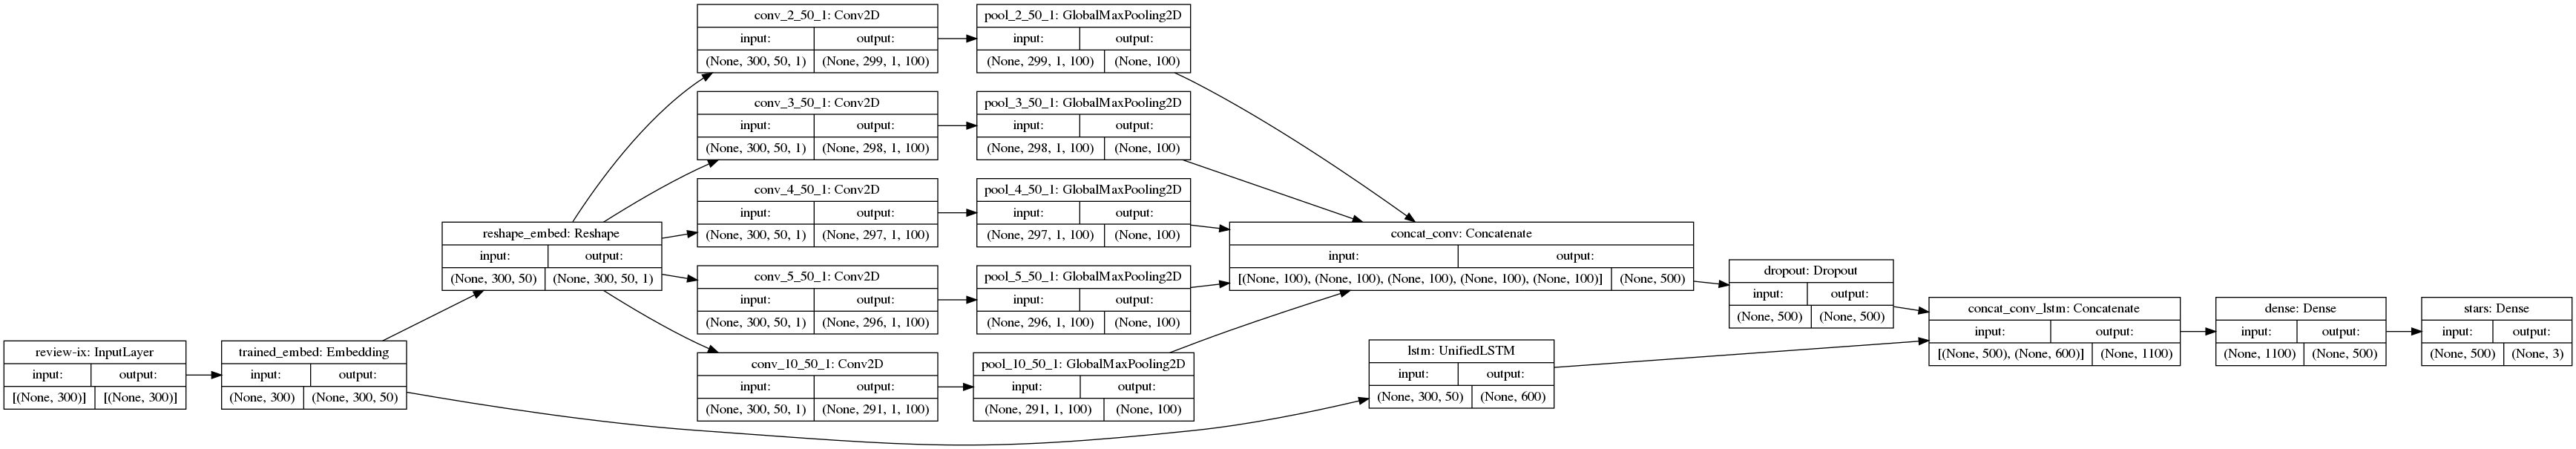

In [121]:
plot_model(teen, show_shapes=True, rankdir='LR', to_file='teen_berry_model.png')

In [122]:
log_dir = os.path.join(SRC_DIR, 'logs', 'TeenBerry-{}'.format(datetime.fromtimestamp(time.time()).strftime('%d-%m_%H-%M-%S')))
tb = tf.keras.callbacks.TensorBoard(log_dir=log_dir, write_graph=False, update_freq='batch')

In [123]:
_=teen.fit(dataset['train'], steps_per_epoch=200, epochs=50, 
                             validation_data= dataset['val'], validation_steps=20,
                             callbacks=[tb], class_weight=class_weights['ternary'], verbose=1)

Epoch 1/100
200/200 [==============================] - 39s 193ms/step - loss: 0.7285 - all_acc: 0.6620 - 0_recalll: 0.3974 - 1_recalll: 0.6336 - 2_recalll: 0.7704 - 0_precision: 0.4836 - 1_precision: 0.6396 - 2_precision: 0.6983 - val_loss: 0.5382 - val_all_acc: 0.7602 - val_0_recalll: 0.7536 - val_1_recalll: 0.6644 - val_2_recalll: 0.8548 - val_0_precision: 0.7538 - val_1_precision: 0.7616 - val_2_precision: 0.7608
Epoch 2/100
200/200 [==============================] - 38s 192ms/step - loss: 0.5468 - all_acc: 0.7524 - 0_recalll: 0.7379 - 1_recalll: 0.6928 - 2_recalll: 0.8127 - 0_precision: 0.7501 - 1_precision: 0.7285 - 2_precision: 0.7810 - val_loss: 0.5084 - val_all_acc: 0.7715 - val_0_recalll: 0.7812 - val_1_recalll: 0.7716 - val_2_recalll: 0.7663 - val_0_precision: 0.7450 - val_1_precision: 0.7276 - val_2_precision: 0.8324
Epoch 3/100
200/200 [==============================] - 39s 193ms/step - loss: 0.5228 - all_acc: 0.7689 - 0_recalll: 0.7846 - 1_recalll: 0.6921 - 2_recalll: 0.83

KeyboardInterrupt: 

In [126]:
truth, predictions = [], []
for x, y in dataset['val'].take(100):
    pred = teen(x['review-ix'])
    truth.append(y['stars'].numpy())
    predictions.append(tf.argmax(pred['stars'], axis=-1).numpy())
predictions=np.array(predictions).flatten()
truth = np.array(truth).flatten()
print(classification_report(truth, predictions))

              precision    recall  f1-score   support

           0       0.83      0.77      0.80      1833
           1       0.77      0.77      0.77      5373
           2       0.83      0.84      0.84      5594

    accuracy                           0.80     12800
   macro avg       0.81      0.80      0.80     12800
weighted avg       0.80      0.80      0.80     12800



In [127]:
teen_embedding = teen.layers[1].get_weights()[0]
teen_dict = {key: teen_embedding[val] for key, val in keys_to_ix.items()}

In [129]:
teen_dists, teen_ix = neighbors(teen_dict['pizza'.encode()], teen_dict)
teen_dists[teen_dists.columns[teen_ix]]

,b'pizza',b'bitsy',b'butterfish',b'so-and-so',b'poundcake',b'tatin',b'ravi',b'rumpled',b'ncl',b'botanical',...,b'chagas',b'prides',b'dcd',b'segunda',b'toy',b'tenets',b'10k',b'recco',b'clicking',b'anatomy'
0,0.0,0.3149,0.341596,0.342599,0.356102,0.358983,0.359614,0.368764,0.369737,0.372811,...,1.609885,1.618371,1.625978,1.627291,1.638852,1.640563,1.640691,1.64401,1.649442,1.663991


In [178]:
class MatureBerry:
    
    def build(dropout_rate, lstm_units, kernels, out_units, embedding_array):
        ix_input = Input(shape=(max_length,), name='review-ix')
        
        embedding = Embedding(input_dim=len(glove_lookup_array), output_dim=glove_dim, 
                              input_length=max_length, name='trained_embed', weights=[embedding_array], trainable=False)(ix_input)
        
        channel_embedding = Reshape(target_shape=(max_length, glove_dim, 1), name='reshape_embed')(embedding)
        
        branches = []
        names = {}
        for kernel in kernels:
            if (kernel['height'], kernel['width']) in names:
                names[(kernel['height'], kernel['width'])] = i = names[(kernel['height'], kernel['width'])] + 1
            else:
                names[(kernel['height'], kernel['width'])] = i = 1
            branch = Conv2D(kernel['filters'], (kernel['height'], kernel['width']), activation='relu', 
                            name='conv_{}_{}_{}'.format(kernel['height'], kernel['width'], i), 
                            padding='valid')(channel_embedding)
            branch = GlobalMaxPool2D(name='pool_{}_{}_{}'.format(kernel['height'], kernel['width'], i))(branch)
            branches.append(branch)
        
#         lstm_out = LSTM(units=lstm_units, name='lstm')(embedding)
        x = Concatenate(name='concat_conv')(branches)
        
        x = Dropout(rate=dropout_rate, name='dropout')(x)
#         x = Concatenate(name='concat_conv_lstm')([x, lstm_out])
        x = Dense(500, activation='relu', name='dense')(x)
        out = Dense(out_units, activation='softmax', name='stars')(x)
        
        return tf.keras.models.Model(inputs={'review-ix': ix_input}, 
                                     outputs={'stars': out}, name='MatureBerry')
        
    @tf.function
    def loss_fn(truth, logits):
        loss = tf.keras.losses.sparse_categorical_crossentropy(truth, logits)
        return loss

In [185]:
mature = MatureBerry.build(kernels=kernels, dropout_rate=.2, out_units=5, lstm_units=600, embedding_array=teen_embedding)
adam = tf.keras.optimizers.Adam()
mature.compile(optimizer=adam, metrics={'stars': star_metrics} ,loss={'stars': MatureBerry.loss_fn})

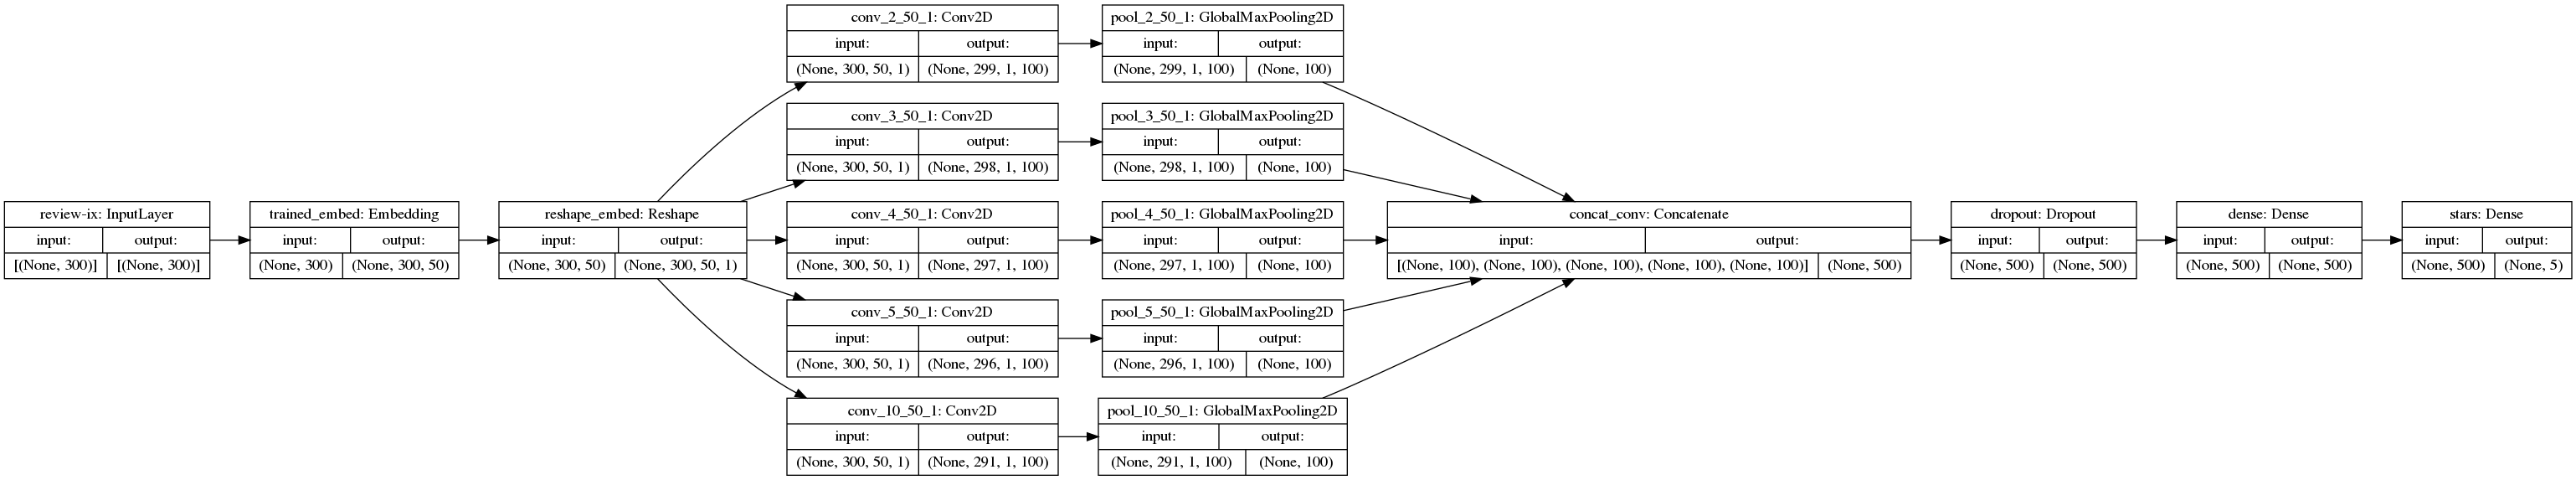

In [180]:
plot_model(mature, show_shapes=True, rankdir='LR', to_file='mature_berry_model.png')

In [186]:
log_dir = os.path.join(SRC_DIR, 'logs', 'MatureBerry-{}'.format(datetime.fromtimestamp(time.time()).strftime('%d-%m_%H-%M-%S')))
tb = tf.keras.callbacks.TensorBoard(log_dir=log_dir, write_graph=False, update_freq='batch')

In [187]:
_=mature.fit(dataset['train'], steps_per_epoch=200, epochs=50, 
                             validation_data= dataset['val'], validation_steps=20,
                             callbacks=[tb], class_weight=class_weights['five'], verbose=1)

Epoch 1/50
200/200 [==============================] - 22s 109ms/step - loss: 1.3257 - all_acc: 0.4632 - 0_recalll: 0.1201 - 1_recalll: 0.0000e+00 - 2_recalll: 0.0059 - 3_recalll: 0.0443 - 4_recalll: 0.9742 - 0_precision: 0.1739 - 1_precision: 0.0000e+00 - 2_precision: 0.0457 - 3_precision: 0.1223 - 4_precision: 0.4752 - val_loss: 1.1646 - val_all_acc: 0.5172 - val_0_recalll: 0.2848 - val_1_recalll: 0.0000e+00 - val_2_recalll: 0.0576 - val_3_recalll: 0.3654 - val_4_recalll: 0.8746 - val_0_precision: 0.6750 - val_1_precision: 0.0000e+00 - val_2_precision: 0.2600 - val_3_precision: 0.3114 - val_4_precision: 0.5848
Epoch 2/50
200/200 [==============================] - 22s 111ms/step - loss: 1.0552 - all_acc: 0.5667 - 0_recalll: 0.6899 - 1_recalll: 0.0152 - 2_recalll: 0.1940 - 3_recalll: 0.3190 - 4_recalll: 0.8407 - 0_precision: 0.5265 - 1_precision: 0.0938 - 2_precision: 0.3552 - 3_precision: 0.4251 - 4_precision: 0.6514 - val_loss: 0.9562 - val_all_acc: 0.6004 - val_0_recalll: 0.7106 - va

KeyboardInterrupt: 

In [163]:
truth, predictions = [], []
for x, y in dataset['val'].take(100):
    pred = mature(x['review-ix'])
    truth.append(y['stars'].numpy())
    predictions.append(tf.argmax(pred['stars'], axis=-1).numpy())
predictions=np.array(predictions).flatten()
truth = np.array(truth).flatten()
print(classification_report(truth, predictions))

              precision    recall  f1-score   support

           0       0.79      0.72      0.75      1833
           1       0.76      0.71      0.73      5373
           2       0.79      0.86      0.82      5594

    accuracy                           0.78     12800
   macro avg       0.78      0.76      0.77     12800
weighted avg       0.78      0.78      0.77     12800



In [164]:
mature_embedding = mature.layers[1].get_weights()[0]
mature_dict = {key: mature_embedding[val] for key, val in keys_to_ix.items()}

In [167]:
mature_dists, mature_ix = neighbors(mature_dict['loved'.encode()], mature_dict)
mature_dists[mature_dists.columns[mature_ix]]

,b'loved',b'elazar',b'patro',b'tubule',b'mines',b'washlet',b'sadie',b'autem',b'weft',b'straten',...,b'zoldan',b'paradies',b'speros',b'ultras',b'shuttering',b'mealey',b'limelight',b'javale',b'flatter',b'perrault'
0,0.0,0.384605,0.405863,0.463439,0.471407,0.473811,0.475946,0.481688,0.483669,0.487023,...,1.522145,1.524322,1.526691,1.528715,1.533502,1.537298,1.543703,1.550598,1.584278,1.597305


## Automated Testing

In [ ]:
try:
    histories
except:
    histories, reports = { }, { }

In [ ]:
possible_heights = list(np.arange(5, step=1)+2) + list(np.arange(10, 50, step=5)) #+ list(np.arange(50, 101, step=10))
possible_num_branches = list(np.arange(4, 11, step=2))
possible_filters = list(np.arange(200, 501, step=100))
possible_dropouts = list(np.arange(.1, .51, step=.1))

In [ ]:
print('possible_heights: {}'.format(possible_heights))
print('possible_num_branches: {}'.format(possible_num_branches))
print('possible_filters: {}'.format(possible_filters))
print('possible_dropouts: {}'.format(possible_dropouts))

In [ ]:
def save_report_histories():
    save_pickle('histories.pkl', reports)
    save_pickle('reports.pkl', reports)


In [ ]:
def load_report_histories():
    return (load_pickle('histories.pkl'),
            load_pickle('reports.pkl'))

In [ ]:
possible_heights = set(possible_heights) #+ list(np.arange(50, 101, step=10)))
possible_num_branches = shuffle(possible_num_branches)
possible_filters = shuffle(possible_filters)
possible_dropouts = shuffle(possible_dropouts)
histories, reports = load_report_histories()
i = 0
for num_branches in possible_num_branches:
    subsets = find_subsets_of_n(possible_heights, num_branches)
    subsets = shuffle(subsets)
    for heights in subsets:
        for filters in possible_filters:
            for dropout_rate in possible_dropouts:
                
                params = (tuple(heights), filters, dropout_rate)
                if params in reports:
                    continue
                print(params)
                kernels = [get_kernel_spec(filters=filters, height=h, width=glove_dim) for h in heights]
                baby = BabyBlueberry.build(kernels=kernels, dropout_rate=dropout_rate)
                adam = tf.keras.optimizers.Adam()
                baby.compile(optimizer=adam, metrics={'stars': star_metrics} ,loss={'stars': BabyBlueberry.loss_fn})
                log_dir = os.path.join(SRC_DIR, 'logs', 'CONV-{}'.format(datetime.fromtimestamp(time.time()).strftime('%H-%M-%S_%m-%d')))
                tb = tf.keras.callbacks.TensorBoard(log_dir=log_dir, write_graph=False, update_freq='batch')
                histories[params] = baby.fit(dataset['train'], steps_per_epoch=100, epochs=5, 
                                             validation_data= dataset['val'], validation_steps=10,
                                             callbacks=[tb], class_weight=class_weights, verbose=1)
                predictions, truth = [], []
                for x, y in dataset['val'].take(100):
                    pred = baby.predict_on_batch(x)
                    truth.append(y['stars'].numpy())
                    predictions.append(tf.argmax(pred['stars'], axis=-1).numpy())
                predictions=np.array(predictions).flatten()
                truth = np.array(truth).flatten()
                reports[params] = classification_report(truth, predictions)
                print(reports[params])
                save_report_histories()

In [ ]:
save_pickle('reports.pkl', reports)
save_pickle('histories.pkl', histories)

In [ ]:
dataset['train'].shuffle

In [ ]:
for x, y in dataset['train']:break
truth = y['stars']
pred = baby(x['review'])['stars']

In [ ]:
print(classification_report(truth, predictions))